In [12]:
import torch
from tqdm import tqdm
import random
import numpy as np

import torchvision.datasets
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [13]:
#MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
#MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)
MNIST_train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [15]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.act = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=2)
        self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3, padding=0)

        self.conv2_1 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 32, 120)
        self.fc2   = torch.nn.Linear(120, 20)
        self.fc3   = torch.nn.Linear(20, 40)
        self.fc4 = torch.nn.Linear(40, 10)
    
    def forward(self, x):
        
        x = self.conv1_1(x)
        x = self.act(x)
        x = self.conv1_2(x)
        x = self.act(x)
        x = self.max_pool(x)
        x = self.act(x)
        
        x = self.conv2_1(x)
        x = self.act(x)
        x = self.conv2_2(x)
        x = self.act(x)
        x = self.avg_pool(x)
        x = self.act(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.fc4(x)
        
        return x

In [16]:
lenet5 = LeNet5()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1e-4)

In [18]:
batch_size = 100

test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm(range(40)):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history += [loss(test_preds, y_test).data.cpu()]
    
    forecast = test_preds

100%|██████████| 40/40 [01:54<00:00,  2.87s/it]


Min error is tensor(0.0283)


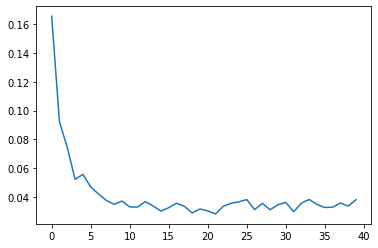

In [8]:
# MNIST Loss

In [9]:
# MNIST confusion matrix

[[975, 0, 0, 0, 0, 1, 1, 0, 1, 2],
 [1, 1127, 0, 3, 0, 0, 2, 0, 1, 1],
 [1, 0, 1024, 1, 1, 0, 0, 1, 4, 0],
 [0, 0, 1, 1008, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 966, 0, 2, 0, 1, 13],
 [2, 0, 0, 9, 0, 877, 1, 0, 2, 1],
 [2, 2, 0, 0, 0, 2, 950, 0, 1, 1],
 [0, 2, 3, 0, 0, 0, 0, 1017, 1, 5],
 [2, 0, 0, 2, 0, 0, 0, 0, 966, 4],
 [2, 0, 0, 0, 5, 2, 0, 0, 0, 1000]]

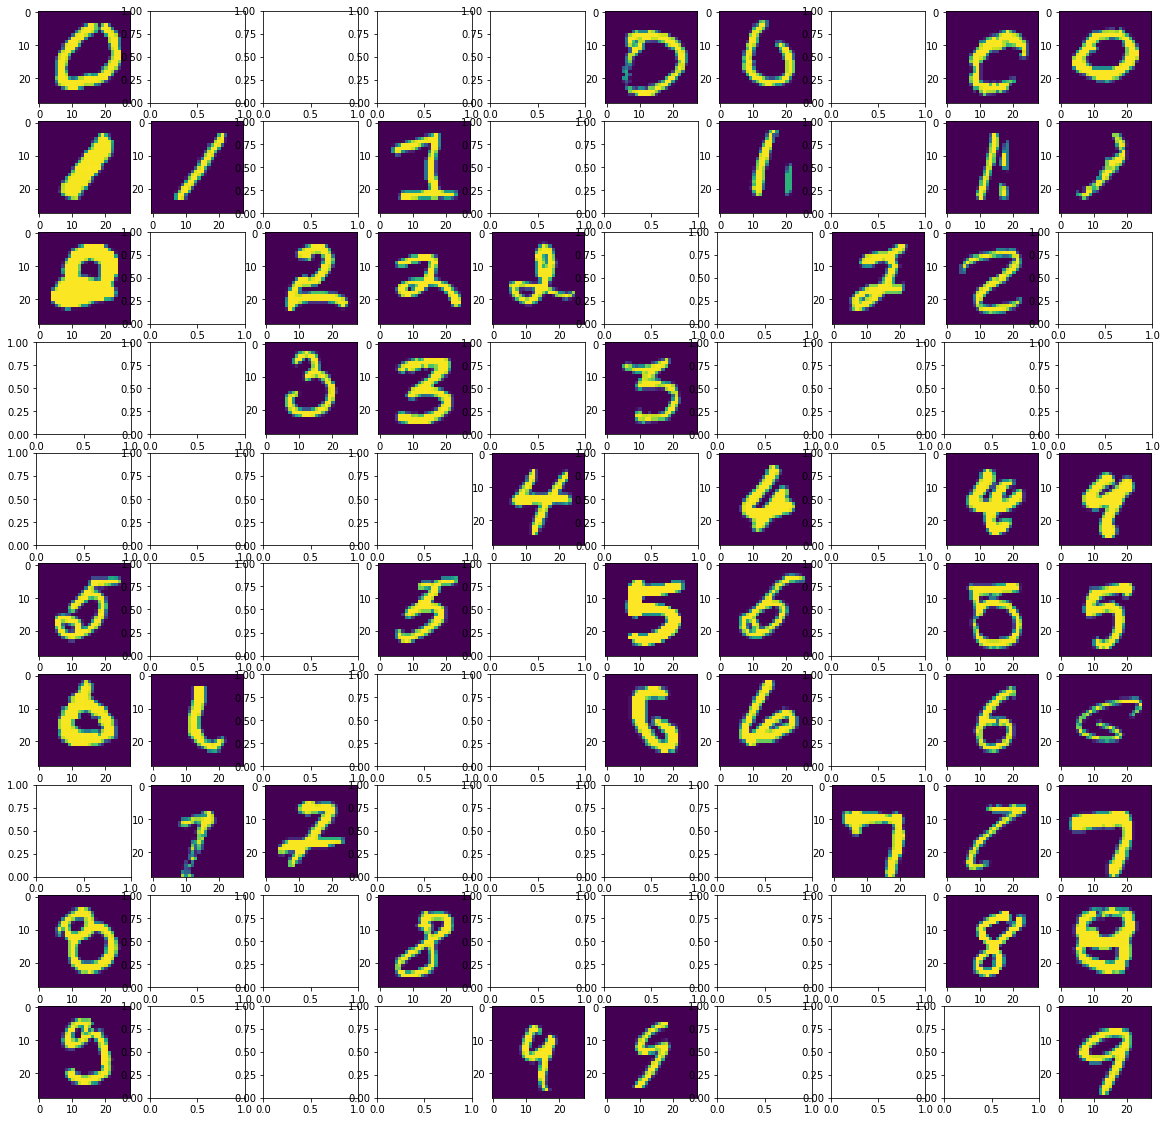

In [11]:
# MNIST showcase

Min error is tensor(0.2694)


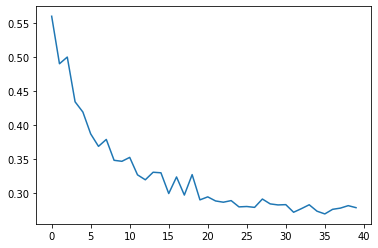

In [19]:
print ("Min error is", min(test_loss_history))
plt.plot(test_loss_history)

In [20]:
conf_matrix = [[0 for x in range(10)] for y in range(10)]

pred = forecast.argmax(dim=1).data.cpu()
labels = y_test.cpu().numpy()

for i in range(len(labels)):
  conf_matrix[labels[i]][pred[i]] += 1

conf_matrix

[[818, 1, 16, 20, 3, 0, 134, 0, 7, 1],
 [1, 975, 3, 16, 1, 0, 4, 0, 0, 0],
 [9, 0, 861, 8, 48, 0, 72, 0, 2, 0],
 [10, 3, 12, 928, 20, 0, 25, 0, 2, 0],
 [2, 0, 54, 37, 837, 0, 69, 0, 1, 0],
 [0, 0, 0, 0, 0, 990, 0, 4, 0, 6],
 [85, 0, 53, 31, 55, 0, 771, 0, 5, 0],
 [0, 0, 0, 0, 0, 40, 0, 928, 0, 32],
 [4, 1, 4, 2, 3, 2, 4, 2, 978, 0],
 [0, 0, 0, 0, 0, 8, 1, 23, 0, 968]]

In [21]:
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


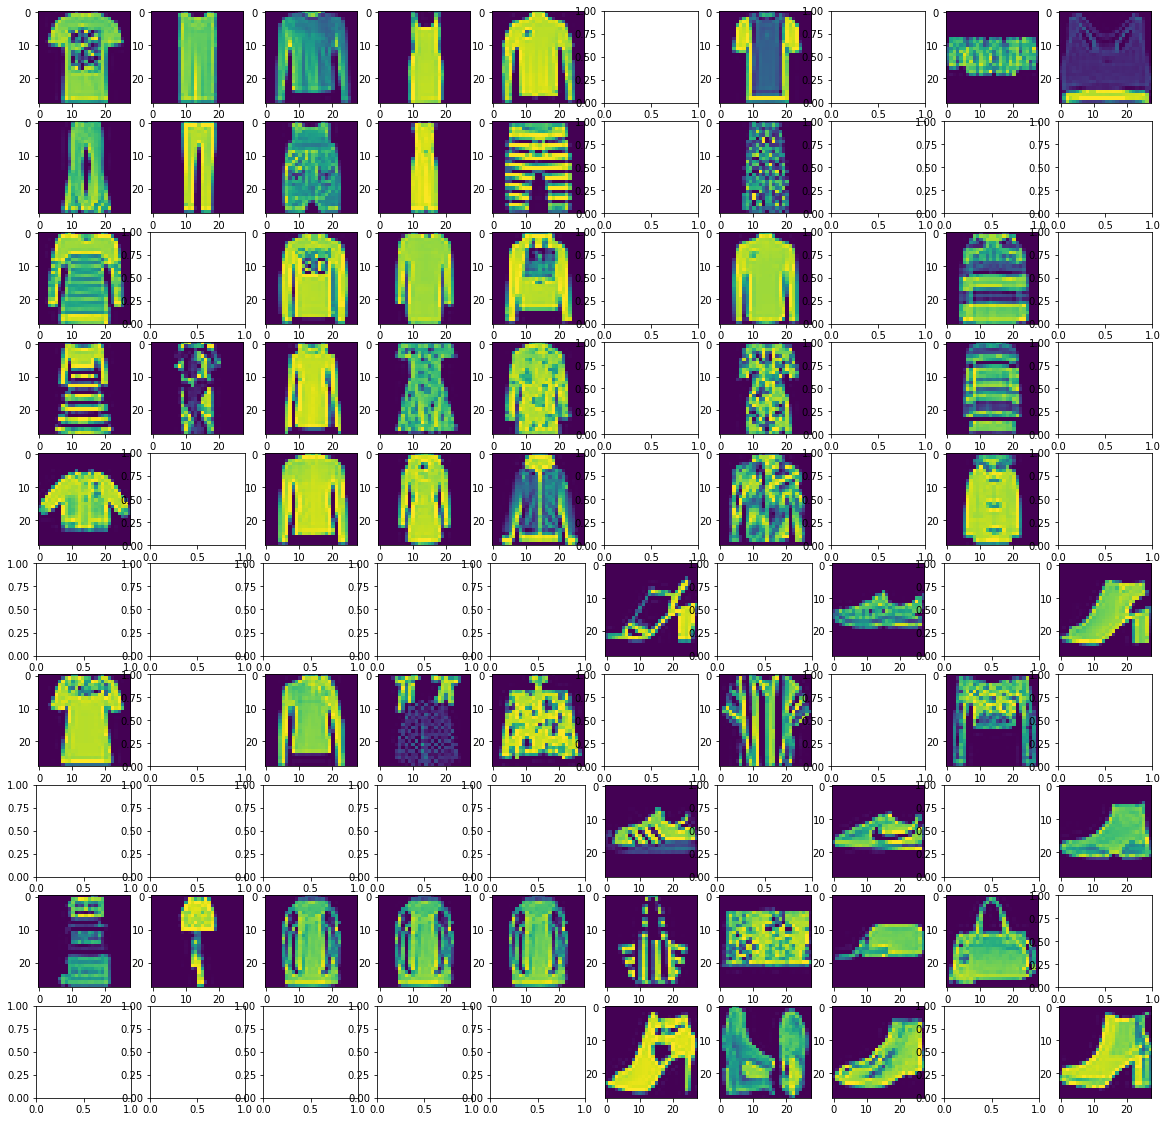

In [22]:
_, pics = plt.subplots(10, 10, figsize=(20, 20))

for class_num in range(10):
  test_objects = []
  
  for i in range(len(y_test)):
    if (y_test[i].item() == class_num):
      test_objects += [i]

  for cur_class in range(10):
    if conf_matrix[class_num][cur_class] == 0:
      continue

    max_prob = -float("inf")
    max_index = -1

    for test_obj in test_objects:
      f = forecast[test_obj][cur_class].item()
      if f > max_prob:
        max_prob = f
        max_index = test_obj
      
    pics[class_num, cur_class].imshow(X_test[max_index])

plt.show()